In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data1 = pd.read_csv('../data/kc_house_data.csv')

data1.head()


/home/linhvt/Projects/github.com/vitalivu/int6051-hoc-may-thong-ke/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
features = data1.corr()['price'].drop(['price', 'lat', 'long']).sort_values(ascending=False)[:15].index.tolist()
features

['sqft_living',
 'grade',
 'sqft_above',
 'sqft_living15',
 'bathrooms',
 'view',
 'sqft_basement',
 'bedrooms',
 'waterfront',
 'floors',
 'yr_renovated',
 'sqft_lot',
 'sqft_lot15',
 'yr_built',
 'condition']

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data1, train_size=0.7, random_state=3)
train_data.shape, test_data.shape

((15129, 21), (6484, 21))

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

pipelines = []
seed = 2

pipelines.append(("Scaled_Ridge", Pipeline([("Scaler", StandardScaler()),
                                            ("Ridge", Ridge(random_state=seed, tol=10))])))
pipelines.append(("Scaled_Lasso", Pipeline([("Scaler", StandardScaler()),
                                            ("Lasso", Lasso(random_state=seed, tol=10))])))

pipelines.append(("Scaled_KNN_reg", Pipeline([("Scaler", StandardScaler()),
                                              ("KNN_reg", KNeighborsRegressor())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 10
results, names = [], []
for name, model in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=None)
    cv_results = cross_val_score(model, train_data[features], train_data['price'], cv=kfold, scoring=scoring, n_jobs=-1)
    names.append(name)
    results.append(cv_results)
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled_Ridge: 0.652022 (+/- 0.018853)
Scaled_Lasso: 0.608718 (+/- 0.020484)
Scaled_KNN_reg: 0.682335 (+/- 0.017376)


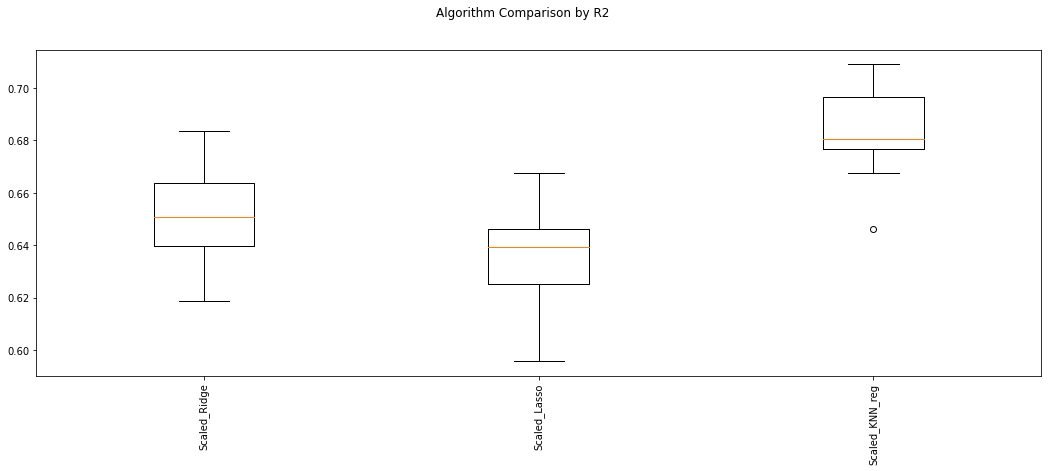

In [5]:
import matplotlib.pyplot as plt

# boxplot algorithm comparison
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Algorithm Comparison by R2')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.show()

In [6]:
evaluation = pd.DataFrame({'Model': [],
                           'Details': [],
                           'Root Mean Squared Error (RMSE)': [],
                           'R-squared (training)': [],
                           'Adjusted R-squared (training)': [],
                           'R-squared (test)': [],
                           'Adjusted R-squared (test)': [],
                           '10-Fold Cross Validation': []})


def adjustedR2(r2, n, k):
    return r2 - (k - 1) / (n - k) * (1 - r2)


# DISPLAY MODELLING
import seaborn as sns


def model_performance_sc_plot(predictions, labels, title):
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    performance_df = pd.DataFrame({"Label": labels})
    performance_df["Prediction"] = predictions
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

### 1. Model Decision tree

In [7]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=seed)
dt.fit(train_data[features], train_data['price'])

pred1 = dt.predict(test_data[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'], pred1)), '.3f'))
rtrcm1 = float(format(dt.score(train_data[features], train_data['price']), '.3f'))
artrcm1 = float(format(adjustedR2(dt.score(train_data[features], train_data['price']),
                                  train_data.shape[0],
                                  len(features)), '.3f'))
rtecm1 = float(format(dt.score(test_data[features], test_data['price']), '.3f'))
artecm1 = float(format(adjustedR2(dt.score(test_data[features], test_data['price']),
                                  test_data.shape[0],
                                  len(features)), '.3f'))
cv1 = float(format(cross_val_score(dt, data1[features], data1['price'], cv=5).mean(), '.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree', 'selected features', rmsecm1, rtrcm1, artrcm1, rtecm1, artecm1, cv1]
evaluation.sort_values(by='10-Fold Cross Validation', ascending=False)
evaluation

NameError: name 'pred3' is not defined

In [ ]:
model_performance_sc_plot(pred1, test_data['price'], 'Validation')

### 2. Model KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(train_data[features], train_data['price'])

pred2 = knn.predict(test_data[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'], pred2)), '.3f'))
rtrcm2 = float(format(knn.score(train_data[features], train_data['price']), '.3f'))
artrcm2 = float(format(adjustedR2(knn.score(train_data[features], train_data['price']),
                                  train_data.shape[0],
                                  len(features)), '.3f'))
rtecm2 = float(format(knn.score(test_data[features], test_data['price']), '.3f'))
artecm2 = float(
    format(adjustedR2(knn.score(test_data[features], test_data['price']),
                      test_data.shape[0],
                      len(features)), '.3f'))
cv2 = float(format(cross_val_score(knn, data1[features], data1['price'], cv=10).mean(), '.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['KNN', 'selected features', rmsecm2, rtrcm2, artrcm2, rtecm2, artecm2, cv2]
evaluation.sort_values(by='10-Fold Cross Validation', ascending=False)
evaluation

In [ ]:
model_performance_sc_plot(pred2, test_data['price'], 'Validation')

### 3. Model linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_data[features], train_data['price'])

pred3 = lr.predict(test_data[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'], pred3)), '.3f'))
rtrcm3 = float(format(lr.score(train_data[features], train_data['price']), '.3f'))
artrcm3 = float(format(adjustedR2(lr.score(train_data[features], train_data['price']),
                                  train_data.shape[0],
                                  len(features)), '.3f'))
rtecm3 = float(format(lr.score(test_data[features], test_data['price']), '.3f'))
artecm3 = float(
    format(adjustedR2(lr.score(test_data[features], test_data['price']),
                      test_data.shape[0],
                      len(features)), '.3f'))
cv3 = float(format(cross_val_score(lr, data1[features], data1['price'], cv=10).mean(), '.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Linear regression', 'selected features', rmsecm3, rtrcm3, artrcm3, rtecm3, artecm3, cv3]
evaluation.sort_values(by='10-Fold Cross Validation', ascending=False)
evaluation

In [ ]:
model_performance_sc_plot(pred3, test_data['price'], 'Validation')




